In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import librosa
import IPython.display as ipd

In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/sounds/audio_data.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/content/working')
print('After zip extraction:')
print(os.listdir('/content/working/'))

After zip extraction:
['main.ipynb', 'sample_submission.csv', 'audio_test', 'test_filenames.csv', 'environment.yml', 'audio_train', 'train.csv']


In [ ]:
def get_mfcc(wav_file_path):
  y, sr = librosa.load(wav_file_path)
  mfcc = np.array(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40))
  return mfcc

In [ ]:
def get_log_melspectrogram(wav_file_path):
  y, sr = librosa.load(wav_file_path)
  melsepc=librosa.feature.melspectrogram(y=y, sr=sr,n_fft=2048, hop_length=512, n_mels=10)
  logspec = np.array(librosa.power_to_db(melsepc))
  return logspec

For musical pieces

In [ ]:
def get_chroma_vector(wav_file_path):
  y, sr = librosa.load(wav_file_path)
  chroma = np.array(librosa.feature.chroma_stft(y=y, sr=sr))
  return chroma

In [ ]:
def get_tonnetz(wav_file_path):
  y, sr = librosa.load(wav_file_path)
  tonnetz = np.array(librosa.feature.tonnetz(y=y, sr=sr))
  return tonnetz

--

In [ ]:
def get_bandwidth(wav_file_path):
  FRAME_SIZE = 2048
  HOP_SIZE = 512
  y,sr=y, sr = librosa.load(wav_file_path)
  bandwidth=np.array(librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE))
  return bandwidth

In [ ]:
def get_sc(wav_file_path):
  FRAME_SIZE = 2048
  HOP_SIZE = 512
  y,sr=y, sr = librosa.load(wav_file_path)
  sc=np.array(librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE))
  return sc

In [ ]:
import math

In [ ]:
def get_ber(wav_file):
  FRAME_SIZE = 2048
  HOP_SIZE = 512
  y,sr= librosa.load(wav_file)
  spectral_bandwidths = np.array(librosa.feature.spectral_contrast(y=y, sr=sr))
  return spectral_bandwidths

In [ ]:
def get_feature(file_path):
  # Extracting MFCC feature
  mfcc = get_mfcc(file_path)
  mfcc_mean = mfcc.mean(axis=1)
  mfcc_min = mfcc.min(axis=1)
  mfcc_max = mfcc.max(axis=1)
  mfcc_feature = np.concatenate( (mfcc_mean, mfcc_min, mfcc_max) )

  # Extracting Log_Mel Spectrogram feature
  melspectrogram = get_log_melspectrogram(file_path)
  melspectrogram_mean = melspectrogram.mean(axis=1)
  melspectrogram_min = melspectrogram.min(axis=1)
  melspectrogram_max = melspectrogram.max(axis=1)
  melspectrogram_feature = np.concatenate( (melspectrogram_mean, melspectrogram_min, melspectrogram_max) )

 # Extracting Bandwidth feature
  bandwidth=get_bandwidth(file_path)
  bandwidth_mean=bandwidth.mean(axis=1)
  bandwidth_min=bandwidth.min(axis=1)
  bandwidth_max=bandwidth.max(axis=1)
  bandwidth_feature=np.concatenate((bandwidth_mean,bandwidth_min,bandwidth_max))

  # Extracting Spectral centroid feature
  centorid=get_sc(file_path)
  centorid_mean=centorid.mean(axis=1)
  centorid_min=centorid.min(axis=1)
  centorid_max=centorid.max(axis=1)
  centorid_feature=np.concatenate((centorid_mean,centorid_min,centorid_max))

  # Extracting BER centroid feature
  ber=get_ber(file_path)
  ber_mean=ber.mean(axis=1)
  ber_min=ber.min(axis=1)
  ber_max=ber.max(axis=1)
  ber_feature=np.concatenate((ber_mean,ber_min,ber_max))

  # Extracting chroma vector feature
 # chroma = get_chroma_vector(file_path)
 # chroma_mean = chroma.mean(axis=1)
 # chroma_min = chroma.min(axis=1)
 # chroma_max = chroma.max(axis=1)
 # chroma_feature = np.concatenate( (chroma_mean, chroma_min, chroma_max) )

  # Extracting tonnetz feature
 # tntz = get_tonnetz(file_path)
#  tntz_mean = tntz.mean(axis=1)
#  tntz_min = tntz.min(axis=1)
 # tntz_max = tntz.max(axis=1)
#  tntz_feature = np.concatenate( (tntz_mean, tntz_min, tntz_max) ) 
  feature = np.concatenate( (melspectrogram_feature, mfcc_feature) )
  return feature

In [ ]:
from tqdm import tqdm
import pandas as pd

In [ ]:
features = []
labels = []
audio_dataset_path='/content/working/audio_train'
metadata=pd.read_csv("/content/working/train.csv")
for index_num,row in tqdm(metadata.iterrows()):
    file_name =os.path.join(os.path.abspath(audio_dataset_path)+'/'+str(row["fname"]))
    label=row["label"]
    features.append(get_feature(file_name))
    labels.append(label)

1869it [05:21,  5.81it/s]


In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(labels))

In [ ]:

features = np.array(features)
y = np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(features,y,test_size=0.2,random_state=0)

In [ ]:
X_train.shape

(1495, 150)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
model=keras.Sequential([
    layers.Dense(300,input_shape=(150,)),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Dense(200),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Dense(100),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Dense(10),
    layers.Activation('softmax'),
])

In [ ]:
model.compile(
    # Optimizer
    optimizer=keras.optimizers.RMSprop(),
    # Loss function to minimize
    loss=keras.losses.CategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.CategoricalAccuracy()],
)


In [ ]:

X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_test_np = np.array(X_test)
y_test_np = np.array(y_test)

In [ ]:
from datetime import datetime 

num_epochs = 100
num_batch_size = 100

early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
start = datetime.now()

history = model.fit(
    X_train.tolist(), y_train.tolist(),
    verbose=1,
    validation_data=(X_test.tolist(), y_test.tolist()),
    batch_size=num_batch_size,
    epochs=num_epochs,
    callbacks=[early_stopping],
)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
15/15 [==============================] - 1s 42ms/step - loss: 24.3131 - categorical_accuracy: 0.1472 - val_loss: 2.2622 - val_categorical_accuracy: 0.2674
Epoch 2/100
15/15 [==============================] - 0s 12ms/step - loss: 7.4313 - categorical_accuracy: 0.1672 - val_loss: 2.1492 - val_categorical_accuracy: 0.2353
Epoch 3/100
15/15 [==============================] - 0s 15ms/step - loss: 4.2470 - categorical_accuracy: 0.1933 - val_loss: 1.9889 - val_categorical_accuracy: 0.2674
Epoch 4/100
15/15 [==============================] - 0s 13ms/step - loss: 2.9820 - categorical_accuracy: 0.2334 - val_loss: 2.0915 - val_categorical_accuracy: 0.2754
Epoch 5/100
15/15 [==============================] - 0s 12ms/step - loss: 2.4844 - categorical_accuracy: 0.2542 - val_loss: 1.9284 - val_categorical_accuracy: 0.3155
Epoch 6/100
15/15 [==============================] - 0s 13ms/step - loss: 2.2219 - categorical_accuracy: 0.2903 - val_loss: 1.7918 - val_categorical_accuracy: 0.4064
Epo

In [ ]:
from tensorflow.keras import layers

model_2 = keras.Sequential([
    layers.Input(shape=(150,)),
    layers.Reshape((150, 1)),
    layers.Conv1D(filters=64, kernel_size=3, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.2),
    layers.Conv1D(filters=128, kernel_size=3, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.2),
    layers.Conv1D(filters=256, kernel_size=3, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(units=256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=10, activation="softmax")
])



In [ ]:
model_2.compile(
    # Optimizer
    optimizer=keras.optimizers.RMSprop(),
    # Loss function to minimize
    loss=keras.losses.CategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.CategoricalAccuracy()],
)

In [ ]:
from datetime import datetime 

num_epochs = 100
num_batch_size = 50

early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
start = datetime.now()

history = model_2.fit(
    X_train.tolist(), y_train.tolist(),
    verbose=1,
    validation_data=(X_test.tolist(), y_test.tolist()),
    batch_size=num_batch_size,
    epochs=num_epochs,
    callbacks=[early_stopping],
)


duration = datetime.now() - start
print("Training completed in time: ", duration)

In [ ]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)

In [ ]:
test_accuracy

[0.7446562647819519, 0.7780748605728149]

In [ ]:
test_accuracy2=model_2.evaluate(X_test,y_test,verbose=0)

In [ ]:
test_accuracy2

[0.5707608461380005, 0.8208556175231934]

In [ ]:
history_df = pd.DataFrame(history.history)

<Axes: title={'center': 'Accuracy'}>

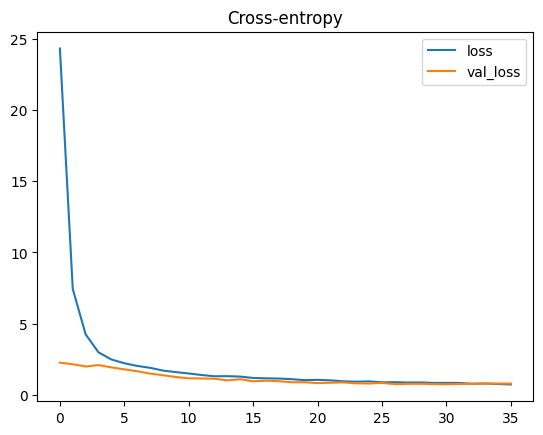

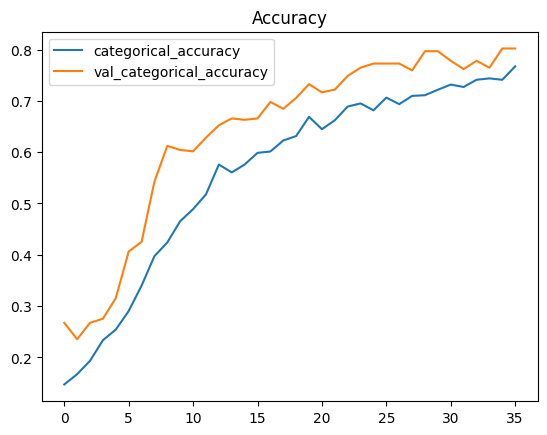

In [ ]:
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot(title="Accuracy")